In [1]:
import numpy as np
import scipy
import scipy.stats
import scipy.io
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline 
plt.rcParams['figure.figsize'] = [10, 5]
from ipywidgets import interact
import ipywidgets as widgets
import seaborn as sns
from scipy.io import loadmat
import ot
from scipy.ndimage import gaussian_filter1d
from tqdm import tqdm
import functions as fs
import NBdecoder as nb

In [2]:
# %% PARAMETERS
animal = 3
session = '1Square'
smooth_position = True
sigma_pos = 2
ratemap_bins = 25
sigma_ratemaps = 1

filter_rate = True
firingh_th_high = 10 # in Hz
firing_th_low = 0.1


compute = True
output_folder = 'processed_data'




In [3]:
def bin_spikes(spikes, times):
    spike_counts = []
    for cell in range(len(spikes)):
        spike_counts.append(np.histogram(spikes[cell], bins=times)[0])
    return np.asarray(spike_counts)

# import session 
path = f'../../SleepData_Matteo/Open_field/AH{animal}/{session}'
mat = scipy.io.loadmat(path+'/spike_times.mat')
spike_times = mat['spike_times'][0]
spike_times = [i.flatten() for i in spike_times]

mat = scipy.io.loadmat(path+'/trajectorypos.mat')
position = mat['trajectorypos']

mat = scipy.io.loadmat(path+'/pos_times.mat')
pos_times = mat['pos_times'][0]

# SMOOTH AND IMPUTE
position = fs.interpolate_nans(position)

if smooth_position:
    position[:, 0] = gaussian_filter1d(position[:, 0], sigma_pos)
    position[:, 1] = gaussian_filter1d(position[:, 1], sigma_pos)

# %% CALCULATE RATEMAPS
firing_rate_maps = []
for cell in range(len(spike_times)):
    rm = fs.compute_ratemap(
        spike_times[cell], position, pos_times, nbins=ratemap_bins, sigma=sigma_ratemaps)
    firing_rate_maps.append(rm/sum(rm.flatten()))

firing_rate_maps = np.asarray(firing_rate_maps)

X = bin_spikes(spike_times,pos_times)

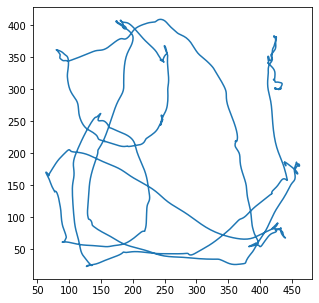

In [4]:
start_time = 3000
end_time = 5000
plt.figure(figsize=(5,5))
plt.plot(position[start_time:end_time,0],position[start_time:end_time,1])

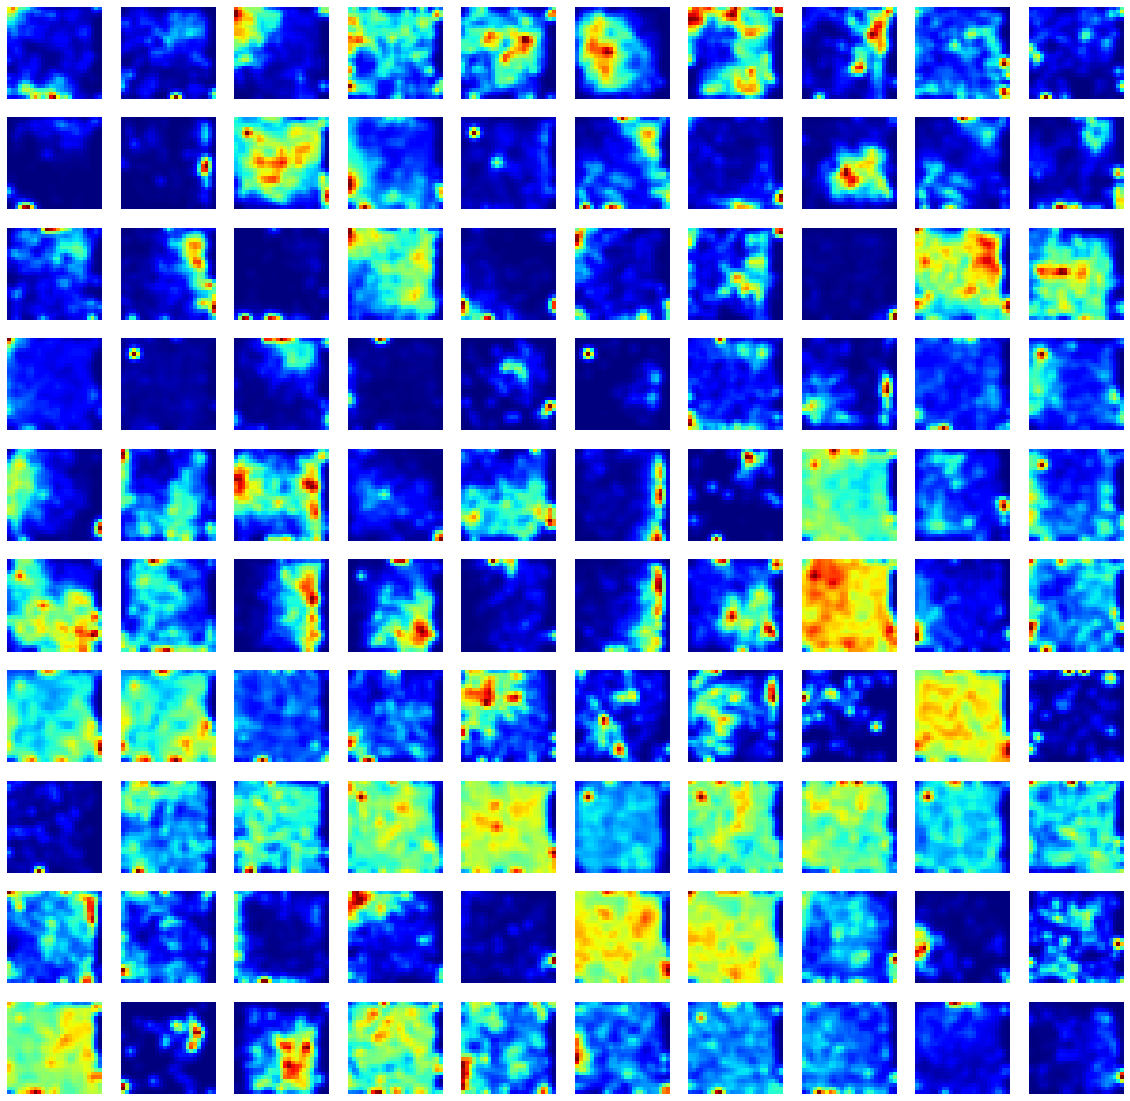

In [5]:
to_plot = 100
n_cols = 10
n_rows = int(np.ceil(to_plot/n_cols))
plt.figure(figsize=(20,20))
for i in range(to_plot):
    ax = plt.subplot(n_rows,n_cols,i+1)
    ax.matshow(firing_rate_maps[i],aspect='auto',cmap=plt.cm.jet)
    plt.axis('off')

In [6]:
# loss matrix + normalization
def build_cost_matrix(hist_shape, bin_width=1):
    '''
    takes shape of histogram in bins and linear bin width
    returns cost matrix M, with ditances in the same units as bin width
    '''
    nbx = hist_shape[0]
    nby = hist_shape[1]
    [bin_x, bin_y] = np.meshgrid(
        np.arange(nbx)*bin_width, np.arange(nby)*bin_width)
    bin_x = bin_x.flatten()
    bin_y = bin_y.flatten()
    N = nbx*nby
    M = np.zeros((N, N))
    for i in range(N):
        for j in range(i):
            x1, y1 = bin_x[i], bin_y[i]
            x2, y2 = bin_x[j], bin_y[j]
            M[i, j] = np.sqrt((x2-x1)**2+(y2-y1)**2)
            M[j, i] = np.sqrt((x2-x1)**2+(y2-y1)**2)
    return M




M = build_cost_matrix(firing_rate_maps[0].shape)
M /= M.max()


(array([ 995., 2703., 5154., 7799., 9294., 7235., 3779., 1188.,  262.,
          25.]),
 array([ 0.,  3.,  6.,  9., 12., 15., 18., 21., 24., 27., 30.]),
 <BarContainer object of 10 artists>)

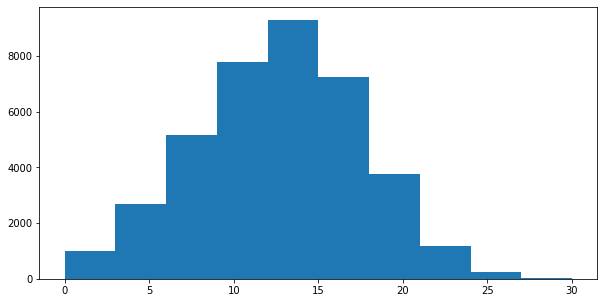

In [7]:
active_cells = [sum(i>0) for i in X.T]
plt.hist(active_cells)

In [8]:

distributions = np.asarray([i.ravel() for i in firing_rate_maps])
distributions = distributions.T/np.sum(distributions,axis=-1)
expected_spikes = np.mean(X,axis=1)

occupancy = nb.compute_occupancy(position,ratemap_bins,sigma=sigma_ratemaps)
occupancy = occupancy.ravel()
occupancy = occupancy/sum(occupancy)

x_bins,y_bins = np.meshgrid(np.linspace(min(position[:,0]),max(position[:,0]),ratemap_bins),
                             np.linspace(min(position[:,1]),max(position[:,1]),ratemap_bins)) 
x_bins = x_bins.ravel()
y_bins = y_bins.ravel()

posteriors = []
decoded_pos = []

time_point = 1000

Xt = X[:,time_point]
active_idxs = np.where(Xt>0)[0]
distributions_t = distributions[:,active_idxs]
weights = Xt[active_idxs]/expected_spikes[active_idxs]
weights = weights/sum(weights)

# wasserstein
reg = 0.005
posterior,log = ot.bregman.barycenter(distributions_t, M, reg, weights,log=True)
posterior = posterior/sum(posterior)
posterior = posterior#*occupancy
decoded_pos.append((x_bins[np.argmax(posterior)],y_bins[np.argmax(posterior)]))
posterior = posterior.reshape((ratemap_bins,ratemap_bins))
posteriors.append(posterior)
    


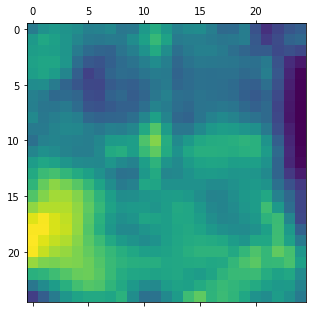

In [57]:
plt.matshow(posterior)

In [14]:
def compute_gammas(distributions,M):
    gammas = []
    x1 = distributions_t[:,0]
    x2 = distributions_t[:,1]
    gamma = ot.emd(x1,x2,M)

    return gammas

def compute_barycenter(distributions,weights, transport_plans):
    




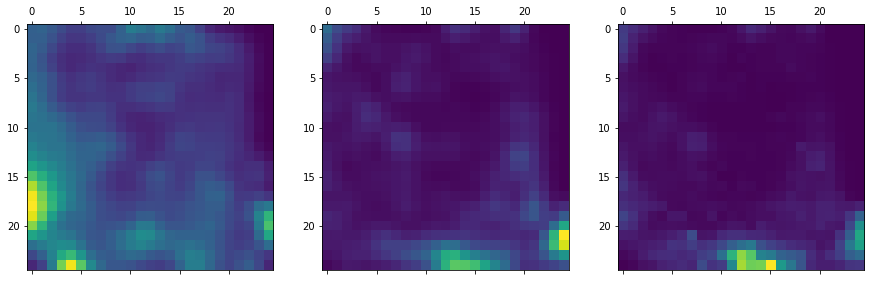

In [54]:
t = 1

plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.matshow(x1.reshape((ratemap_bins,ratemap_bins)))
ax = plt.subplot(1,3,2)
ax.matshow(x2.reshape((ratemap_bins,ratemap_bins)))

ax = plt.subplot(1,3,3)
x_mean = x1 @ (t*gamma + (1-t)*np.identity(gamma.shape[0])/gamma.shape[0]) 
ax.matshow(x_mean.reshape((ratemap_bins,ratemap_bins)))


In [61]:
import numpy as np
import matplotlib.pylab as pl
import ot
import ot.plot
from ot.datasets import make_1D_gauss as gauss

n = 100  # nb bins

# bin positions
x = np.arange(n, dtype=np.float64)

# Gaussian distributions
a = gauss(n, m=20, s=5)  # m= mean, s= std
b = gauss(n, m=60, s=5)

# loss matrix
M = ot.dist(x.reshape((n, 1)), x.reshape((n, 1)))
M /= M.max()


In [63]:
G0 = ot.emd(a, b, M)


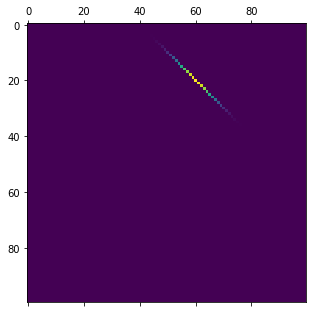

In [65]:
plt.matshow(G0)

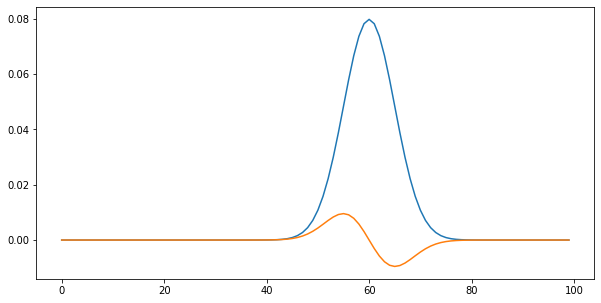

In [123]:
n1 = np.ones(len(G0))
f_x = n1 @ G0
d_x =np.gradient(f_x)
plt.plot(n1 @ G0)
plt.plot(d_x)

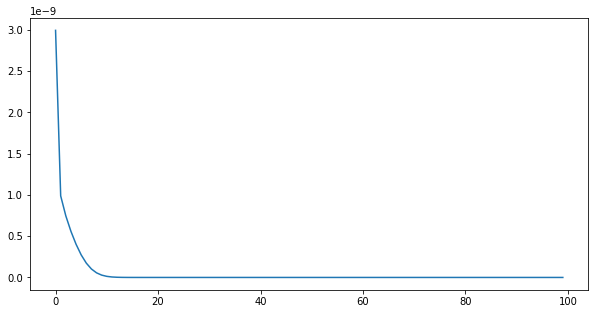

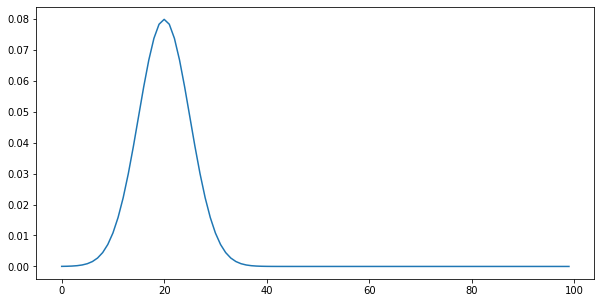

In [126]:
#plt.plot(a)
#plt.plot(b)
t = 0
c = G0 @ ((1-t)*a + t*b)

plt.plot(c)

plt.figure()
d = t*b + (1-t)*a
plt.plot(d)


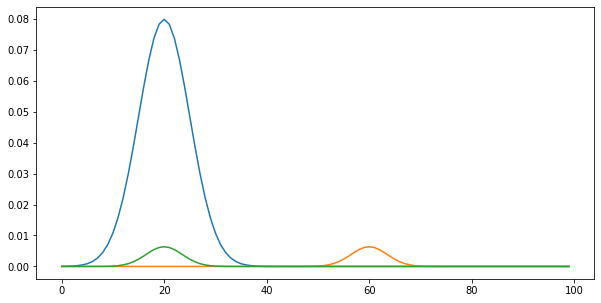

In [113]:
plt.plot(a)
plt.plot(a @ G0)
plt.plot(b @ G0.T)

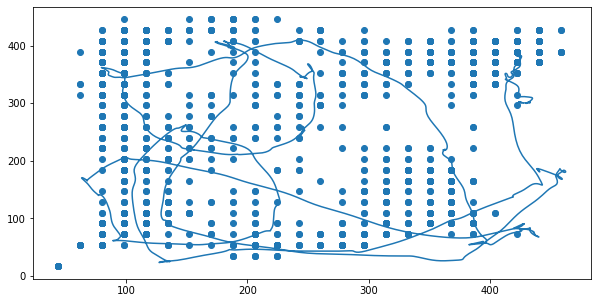

In [116]:
x = [i[0] for i in decoded_pos]
y = [i[1] for i in decoded_pos]
plt.scatter(x,y)
plt.plot(position[start_time:end_time,0],position[start_time:end_time,1])

mse_ot = np.sqrt((x-position[start_time:end_time,0])**2+(y-position[start_time:end_time,1])**2)


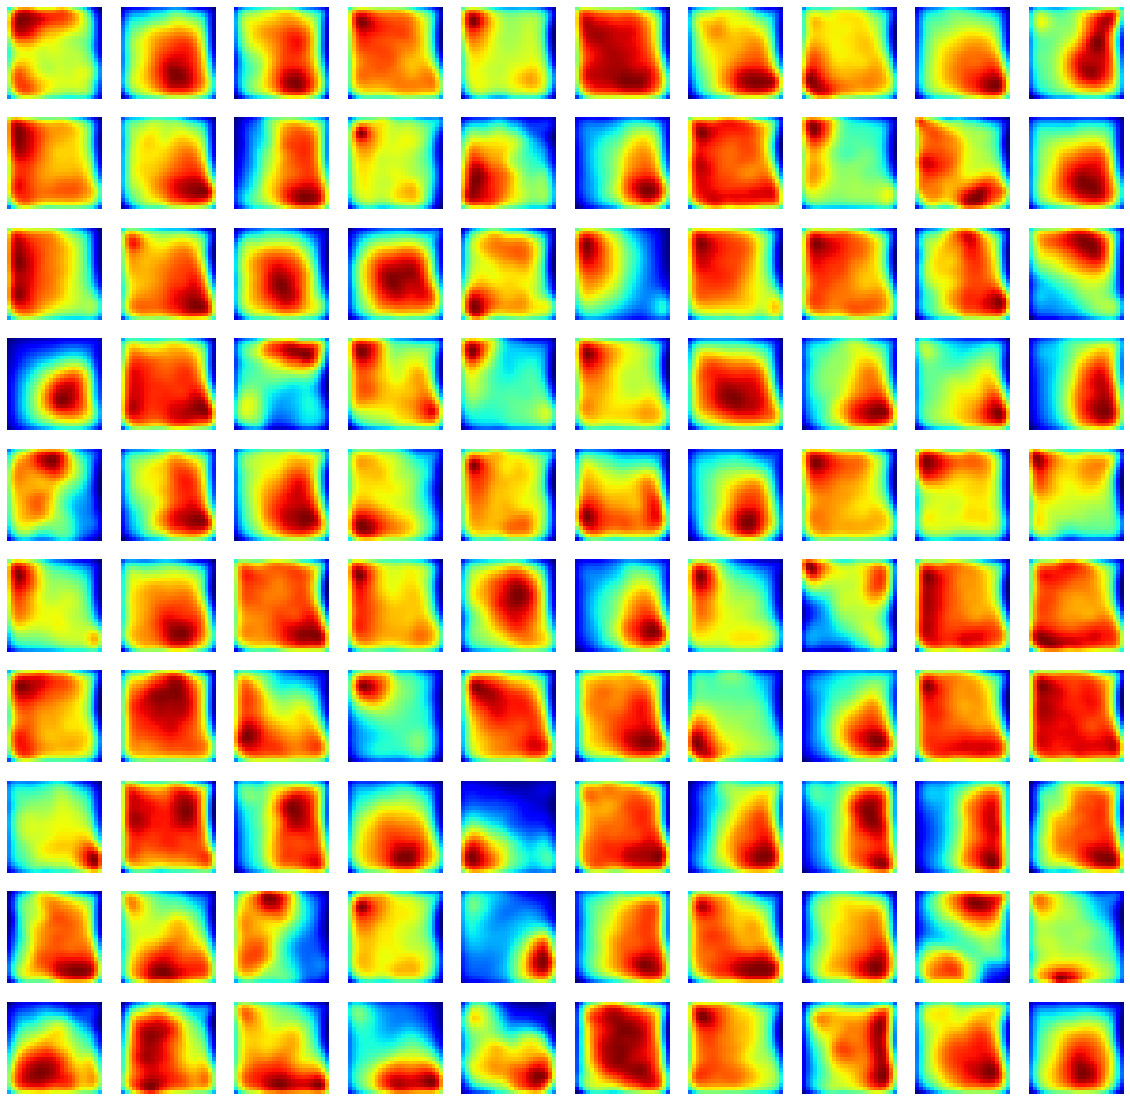

In [117]:
to_plot = 100
n_cols = 10
n_rows = int(np.ceil(to_plot/n_cols))
plt.figure(figsize=(20,20))
for i in range(to_plot):
    ax = plt.subplot(n_rows,n_cols,i+1)
    ax.matshow(posteriors[i],aspect='auto',cmap=plt.cm.jet)
    plt.axis('off')

# NAIVE BAYES

In [118]:
X_nb = X.T[start_time:end_time]
Y_nb = position[start_time:end_time,:]
decoder = nb.NBdecoder2D(n_cells=X_nb.shape[-1],
                                         n_bins_x=ratemap_bins,
                                         n_bins_y=ratemap_bins,
                                         )
decoder.fit(X_nb, Y_nb, sigma=sigma_ratemaps)
Y_pred = decoder.predict_position(X_nb, use_prior=False)
mse = np.sqrt((Y_pred[:,0]-Y_nb[:,0])**2+(Y_pred[:,1]-Y_nb[:,1])**2)

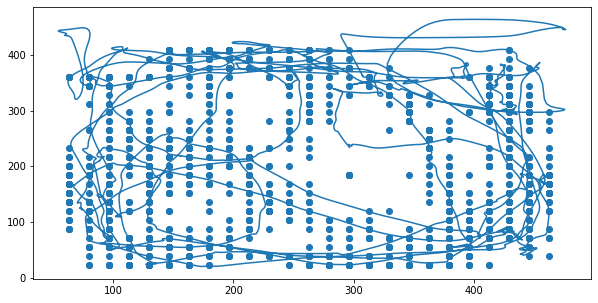

In [119]:
x = [i[0] for i in Y_pred]
y = [i[1] for i in Y_pred]
plt.scatter(x,y)
plt.plot(position[:end_time,0],position[:end_time,1])


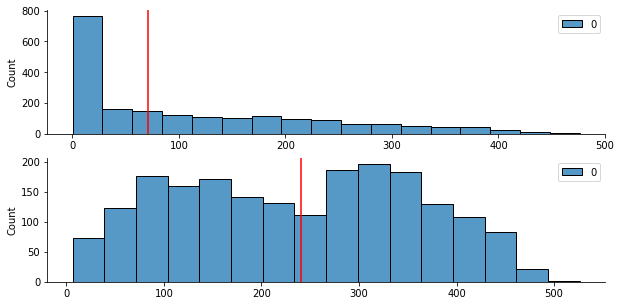

In [120]:
plt.subplot(2,1,1)
sns.histplot(data=[mse])
plt.axvline(x=np.median(mse),c='r')
sns.despine()

plt.subplot(2,1,2)
sns.histplot(data=[mse_ot])
plt.axvline(x=np.median(mse_ot),c='r')
sns.despine()
